In [1]:
# packages 

import mibian
import cvxpy as cp
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np 


In [3]:
#load stock data

underlying = pd.read_csv('C:/Users/theon/Dropbox/Documents/Work/Rhodium/Option Strategy/underlying/Iran.Khodro.csv')
underlying['<DTYYYYMMDD>']=pd.to_datetime(underlying['<DTYYYYMMDD>'].apply(str))
underlying= underlying.set_index('<DTYYYYMMDD>')
underlying=underlying.filter(items=['<CLOSE>'])
underlying=underlying.sort_index()

In [4]:
#load all data 

path = "*.csv"
strike = 2000;
calls = {}
Strikes = []
for fname in glob.glob(path):
    Strikes.append(strike)
    calls[strike]=pd.read_csv(fname)
    calls[strike]['<DTYYYYMMDD>']=pd.to_datetime(calls[strike]['<DTYYYYMMDD>'].apply(str))
    calls[strike] = calls[strike].set_index('<DTYYYYMMDD>')
    calls[strike]=calls[strike].filter(items=['<CLOSE>'])
    calls[strike]=calls[strike].sort_index()
    calls[strike]['strike']=strike
    calls[strike]['underlying']=underlying.loc[calls[strike].index]
    calls[strike]['Time to Maturity']=(max(calls[strike].index)-calls[strike].index).days
    if strike < 5000 :
        strike = strike + 500
    else :
        strike = strike + 1000

In [95]:
#find butterfly arbitrage 

f = 0.1
arbitrage = {}
for date in calls[Strikes[0]].index:
    prices = {}
    for i in range(len(calls)):
        if date in calls[Strikes[i]].index:
            prices[Strikes[i]] = calls[Strikes[i]]['<CLOSE>'][date]
    if len(prices)>2:
        for j in range(len(prices)-2) :
            permium= 2*(1-f)*prices[list(prices.keys())[j+1]]-(1+f)*prices[list(prices.keys())[j]]- (1+f)*prices[list(prices.keys())[j+2]]
            strike_diff = (2*list(prices.keys())[j+1]-list(prices.keys())[j]-list(prices.keys())[j+2])
            margin = 2*calls[Strikes[0]]['underlying'][date]*0.2*(1.05)
            if  permium>strike_diff+margin :
                arbitrage[date] = [Strikes[j],Strikes[j+1],Strikes[j+2]]
print(arbitrage)
len(arbitrage)

{Timestamp('2020-10-03 00:00:00'): [4500, 5000, 6000], Timestamp('2020-10-06 00:00:00'): [4500, 5000, 6000], Timestamp('2020-10-07 00:00:00'): [4500, 5000, 6000], Timestamp('2020-10-10 00:00:00'): [4500, 5000, 6000], Timestamp('2020-10-21 00:00:00'): [4500, 5000, 6000], Timestamp('2020-10-24 00:00:00'): [4500, 5000, 6000], Timestamp('2020-10-26 00:00:00'): [4500, 5000, 6000], Timestamp('2020-11-02 00:00:00'): [4500, 5000, 6000], Timestamp('2020-11-04 00:00:00'): [4000, 4500, 5000], Timestamp('2020-11-07 00:00:00'): [4500, 5000, 6000], Timestamp('2020-12-26 00:00:00'): [3500, 4000, 4500]}


11

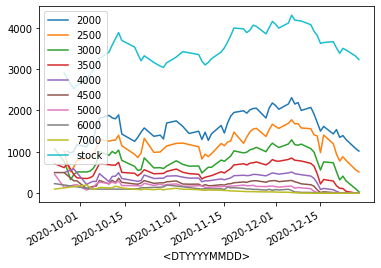

In [82]:
#Option prices + stock visualization 

for i in range(len(calls)):
    price = calls[Strikes[i]]['<CLOSE>']
    price.name = str(Strikes[i])
    price.plot()
price = calls[Strikes[1]]['underlying']
price.name = 'stock'
price.plot()
plt.legend()

In [98]:
# OTM tail option strategy 

f = 0.1
arbitrage = {}
P_L = 0 
purchases = {}
for s in Strikes: 
    purchases[s]=0

for date in calls[Strikes[0]].index[:20]:
    prices = {}
    IV = {}
    for i in range(len(calls)):
        if date in calls[Strikes[i]].index:
            c = mibian.BS([calls[Strikes[i]]['underlying'][date], Strikes[i], 30, calls[Strikes[i]]['Time to Maturity'][date]], callPrice=calls[Strikes[i]]['<CLOSE>'][date])
            prices[Strikes[i]] = calls[Strikes[i]]['<CLOSE>'][date]
            IV[Strikes[i]] = c.impliedVolatility
    for j in range(len(IV)-1):
        slope_neg = True
        slope_pos = True
        slope_pos =slope_pos and IV[list(IV.keys())[j+1]]> IV[list(IV.keys())[j]]
        slope_neg =slope_neg and IV[list(IV.keys())[j+1]]< IV[list(IV.keys())[j]]
    if slope_neg :
        P_L = -prices[min(list(IV.keys()))]
        purchases[min(list(IV.keys()))]= + 1
    if slope_pos : 
        P_L = +prices[max(list(IV.keys()))]
        purchases[max(list(IV.keys()))]= -1
        
print(P_L)

105.0


In [100]:
#computing all BS metrics in a certain period 

IV = []
delta = []
theta = []
gamma = []
vega = []
rho = []
khodro = pd.DataFrame(index = Strikes, columns = ['price'] )

# option market as a way to leverage 

# 0 market goes up 
# 1 market goes down 
# 2 has butterfly 
day = calls[Strikes[0]].index[2]
for i in range(len(calls)):
    if day in calls[Strikes[i]].index:
        c = mibian.BS([calls[Strikes[i]]['underlying'][day], Strikes[i], 30, calls[Strikes[i]]['Time to Maturity'][day]], callPrice=calls[Strikes[i]]['<CLOSE>'][day])
        IV.append(c.impliedVolatility)
        c = mibian.BS([calls[Strikes[i]]['underlying'][day], Strikes[i], 30, calls[Strikes[i]]['Time to Maturity'][day]], volatility=IV[i])
        delta.append(c.callDelta)
        theta.append(c.callTheta)
        gamma.append(c.gamma)
        vega.append(c.vega)
        rho.append(c.callRho)
        khodro['price'].iloc[i] = float(calls[Strikes[i]]['<CLOSE>'][day])
    else:
        c = mibian.BS([calls[Strikes[0]]['underlying'][day], Strikes[i], 30, calls[Strikes[0]]['Time to Maturity'][day]], callPrice=0)
        IV.append(c.impliedVolatility)
        c = mibian.BS([calls[Strikes[0]]['underlying'][day], Strikes[i], 30, calls[Strikes[0]]['Time to Maturity'][day]], volatility=IV[i])
        delta.append(c.callDelta)
        theta.append(c.callTheta)
        gamma.append(c.gamma)
        vega.append(c.vega)
        rho.append(c.callRho)
        khodro['price'].iloc[i] = float("nan")
khodro['delta']=delta
khodro['theta']=theta
khodro['gamma']=gamma
khodro['rho']=rho
khodro['vega']=vega
khodro['IV']=IV
khodro

,price,delta,theta,gamma,rho,vega,IV
2000,1014.0,0.782611,-3.877962,0.000157,2.336350,3.659268,150.329590
2500,632.0,0.663990,-3.715550,0.000261,2.538969,4.538745,112.152100
3000,448.0,0.535463,-3.821574,0.000288,2.197834,4.944687,110.900879
3500,450.0,0.484633,-4.455602,0.000234,1.880704,4.960630,137.130737
4000,590.0,0.512619,-5.737094,0.000173,1.711178,4.961830,185.119629
4500,303.0,0.355419,-4.188712,0.000211,1.445074,4.634621,142.166138
5000,200.0,0.268624,-3.425918,0.000201,1.162843,4.103924,131.591797
6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Implied Volatility')

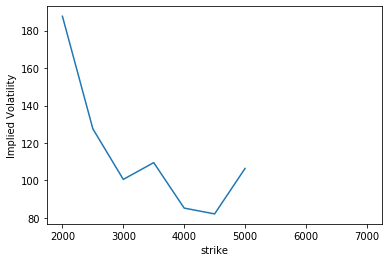

In [68]:
#slope of Implied volatility indicates market mood, upward sloping is positive (market goes up), downward sloping is negative (market goes down)

# Implied volatility as a function of strike 

plt.plot(Strikes, IV)
plt.xlabel('strike')
plt.ylabel('Implied Volatility')


Text(0.5, 1.0, '2020-09-29 00:00:00')

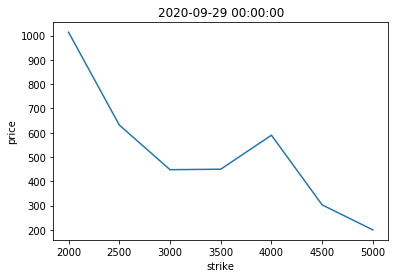

In [102]:
# Price as a function of strike 

plt.plot(Strikes, khodro['price'].tolist())
plt.xlabel('strike')
plt.ylabel('price')
plt.title(str(day))

In [43]:
# an idea for creating proprietary trading strategies using BS parameters as constraints  

khodro = khodro.dropna()
f = 0.1
buys = cp.Variable(len(khodro))
sells = cp.Variable(len(khodro))
bids = np.array(khodro['price'])*(1-1/100*f)
asks = np.array(khodro['price'])*(1+0.5/100*f)
delta = (buys-sells)@khodro['delta']
theta = (buys-sells)@khodro['theta']
gamma = (buys-sells)@khodro['gamma']
vega = (buys-sells)@khodro['vega']
rho = (buys-sells)@khodro['rho']
constraints = [sells>=0,buys>=0]
constraints += [vega>=0,gamma>=0]
constraints += [delta==0]
constraints += [sum(sells)<=sum(buys)]
constraints += [buys@asks-sells@bids<=0]
obj = cp.Maximize(theta)
problem = cp.Problem(obj,constraints)
problem.solve()

inf

In [ ]:
print('buys :',np.round(buys.value,2))
print('sells:',np.round(sells.value,2))
print(round(problem.value,2))